In [2]:
%matplotlib inline

import networkx as nx
from networkx.algorithms import community
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# !pip install gensim
# !pip install datasets
# !pip install scikit-learn matplotlib
# !pip install transformers torch
# !pip install nltk

In [1]:
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.manifold import TSNE
import gensim.downloader as api
import datasets
from nltk.tokenize import word_tokenize
import numpy as np

In [4]:
graph = nx.read_graphml("database\Everything\database_formated_for_NetworkX.graphml")

In [5]:
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

# Print some nodes with attributes
print("Nodes:", list(graph.nodes(data=True))[:5])  # Show first 5 nodes

# Print some edges with attributes
print("Edges:", list(graph.edges(data=True))[:5])  # Show first 5 edges


Number of nodes: 109627
Number of edges: 311654
Nodes: [('n0', {'labels': ':Event', 'id': 'fireColorado2012', 'trecisid': 'TRECIS-CTIT-H-001', 'eventType': 'wildfire'}), ('n1', {'labels': ':Event', 'id': 'costaRicaEarthquake2012', 'trecisid': 'TRECIS-CTIT-H-002', 'eventType': 'earthquake'}), ('n2', {'labels': ':Event', 'id': 'floodColorado2013', 'eventType': 'flood', 'trecisid': 'TRECIS-CTIT-H-003'}), ('n3', {'labels': ':Event', 'id': 'typhoonPablo2012', 'trecisid': 'TRECIS-CTIT-H-004', 'eventType': 'typhoon'}), ('n4', {'labels': ':Event', 'id': 'laAirportShooting2013', 'trecisid': 'TRECIS-CTIT-H-005', 'eventType': 'shooting'})]
Edges: [('n582', 'n0', {'label': 'IS_ABOUT'}), ('n582', 'n99813', {'label': 'HAS_HASHTAG'}), ('n582', 'n100609', {'label': 'HAS_HASHTAG'}), ('n582', 'n562', {'label': 'HAS_CATEGORY'}), ('n583', 'n0', {'label': 'IS_ABOUT'})]


In [6]:
# Extract tweet texts from nodes (assuming 'text' is the attribute storing the tweet)
tweets = [data['text'] for _, data in graph.nodes(data=True) if 'text' in data]

# Display some extracted tweets
print("Sample Tweets:", tweets[:5])

Sample Tweets: ['#colorado. Told you its #amazing http://t.co/6z0Qq7qe', 'RT @northfortynews: Tanker helicopter heads up to Paradise Park to drop water on #HighParkFire. http://t.co/7atRS5cy', '#Evacuation center Cache La Poudre Middle School 3515 West County Road 54G in Laporte. #Colorado #Wildfire', "20F degrees cooler tomorrow in North Central &amp; Northeastern #Colorado. Highs in the mid and upper 70'S. #HighParkFire #COwx #Heat #Coolbreak", 'FEMA has authorized the use of federal funds to help with firefighting costs for the #HighParkFire. http://t.co/whxlpPEP']


##  Word-embeddings (dense vector semantics)

We use word-embeddings to perform opinion mining, following a similar pipeline as before but with modifications to steps ``b) and c)``.


**Step b) Compute Positive and Negative Barycenters**

Instead of computing sentiment scores for each word, we calculate a ``positive`` ($b^{+}$) and a ``negative`` ($b^{-}$) barycenters using the SentiWordnet lexicon:

1. Retrieve all available synsets from SentiWordNet using the ``all_senti_synsets`` function
2. For each synset, compute its positive and negative scores to classify it as either positive or negative.
3. Retrieve the word embedding for the synset's associated word.
4. Maintain two separate lists of word embeddings: one for positive words and one for negative words.
5.  Compute the positive and negative [barycenters](https://fr.wikipedia.org/wiki/Barycentre) ($b^{+}$, $b^{-}$) as the weighted averages (sentiment score) of their respective word embeddings.

**Step c) Aggregate Scores**

To determine the opinion of a sentence:

1. Compute a vector semantic $v(sentence)$ for the sentence as in the previous PW.
2. Compute two distances, a positive distance, $d^{+}_{sentence} = dist(v(sentence), b^{+})$, and a negative distance, $d^{-}_{sentence} = dist(v(sentence), b^{-})$.
3. Then, the sentence is positive if $d^{+} \lt d^{-}$, or negative otherwise.

This method uses the barycenters to establish a reference for positive and negative sentiments, allowing us to assess the sentence's sentiment based on its proximity to these references.


---

# **📌 Steps in Word Embedding Analysis**
1️⃣ Extract tweet texts from the graph.  
2️⃣ Clean and preprocess the text.  
3️⃣ Train or load a word embedding model (Word2Vec, GloVe, BERT, etc.).  
4️⃣ Visualize and analyze the embeddings.  

---

# **✅ 1️⃣ Extract Tweet Texts from the Graph**
Since the dataset is structured as a **graph**, each **tweet** is a **node**. We need to:
- Identify **nodes representing tweets**.
- Extract the **text** associated with each tweet.


---

# **✅ 2️⃣ Preprocess the Text Data**
Before applying embeddings, we need to **clean** the tweets:
- Remove URLs, mentions (@user), hashtags, and punctuation.
- Convert to lowercase.
- Remove stopwords.
- Apply **tokenization** and **lemmatization**.


# **✅ 3️⃣ Train or Use Word Embeddings**

---

# **✅ 4️⃣ Visualizing the Embeddings**
### **Reduce Dimensionality (PCA or t-SNE)**




In [7]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\coral\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [10]:
#Data preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+", '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+|#\w+', '', tweet)  # Remove mentions and hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove punctuation and numbers
    tweet = tweet.lower()  # Convert to lowercase
    tokens = word_tokenize(tweet)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return " ".join(tokens)

# Apply cleaning to all tweets
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets]

# Display some cleaned tweets
print("Cleaned Tweets:", cleaned_tweets[:5])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coral\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coral\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\coral\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaned Tweets: ['told', 'rt tanker helicopter head paradise park drop water', 'center cache la poudre middle school west county road g laporte', 'f degree cooler tomorrow north central amp northeastern high mid upper', 'fema authorized use federal fund help firefighting cost']


✅ 3️⃣ Train or Use Word Embeddings

In [ ]:
#Option 1: Train Word2Vec on the Tweets
from gensim.models import Word2Vec

# Tokenize tweets (split into words)
tokenized_tweets = [tweet.split() for tweet in cleaned_tweets]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=2, workers=4)

# Example: Find words similar to "fire"
print(word2vec_model.wv.most_similar("fire"))


[('wildfire', 0.8293876647949219), ('crushing', 0.779681921005249), ('spring', 0.7335232496261597), ('boulder', 0.7315326929092407), ('lake', 0.7304045557975769), ('collins', 0.7211542725563049), ('road', 0.711025059223175), ('confidence', 0.7072490453720093), ('tansey', 0.7036121487617493), ('pike', 0.6967212557792664)]


In [12]:
#Option 2: Use Pretrained GloVe Embeddings
import gensim.downloader as api

# Load pre-trained GloVe vectors (100D)
glove_model = api.load("glove-wiki-gigaword-100")

# Example: Find similar words to "earthquake"
print(glove_model.most_similar("earthquake"))


[==================================================] 100.0% 128.1/128.1MB downloaded
[('quake', 0.9480070471763611), ('tsunami', 0.8075350522994995), ('temblor', 0.790282666683197), ('magnitude', 0.7707369327545166), ('earthquakes', 0.7257688641548157), ('disaster', 0.7229210138320923), ('aftershock', 0.7178043127059937), ('tremor', 0.7131491303443909), ('tsunamis', 0.7090720534324646), ('quakes', 0.7071856260299683)]


✅ 4️⃣ Visualizing the Embeddings
Reduce Dimensionality (PCA or t-SNE)

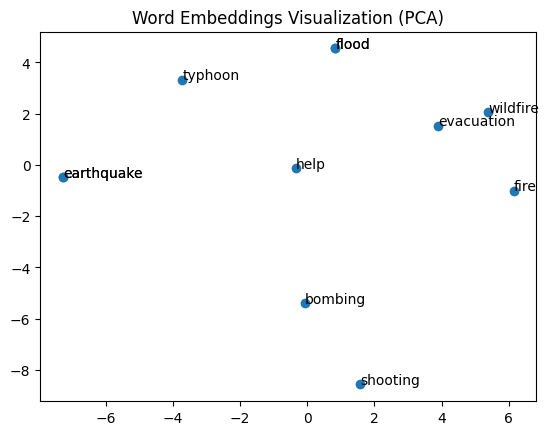

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions of word embeddings
words = ["fire", "earthquake", "flood", "help", "evacuation",'typhoon', 'shooting', 'wildfire', 'bombing', 'earthquake', 'flood']
word_vectors = [word2vec_model.wv[word] for word in words]

pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))
plt.title("Word Embeddings Visualization (PCA)")
plt.show()


✅ 5️⃣ Applying Embeddings to Your Project

In [15]:
from sklearn.cluster import KMeans
#Clustering Tweets Based on Meaning
# Cluster tweets using their embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
tweet_clusters = kmeans.fit_predict(word_vectors)

# Print cluster assignments for the first 5 tweets
print("Tweet Clusters:", tweet_clusters[:5])


Tweet Clusters: [2 0 4 3 1]


In [16]:
#Finding Similar Tweets for Search
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity between tweets
similarity_matrix = cosine_similarity(word_vectors)

# Find most similar tweet to tweet 0
most_similar_idx = similarity_matrix[0].argsort()[-2]  # Exclude itself
print("Tweet:", cleaned_tweets[0])
print("Most Similar Tweet:", cleaned_tweets[most_similar_idx])


Tweet: told
Most Similar Tweet: fema authorized use federal fund help firefighting cost
